In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
os.nice(1)

1

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats

In [5]:
%matplotlib inline

In [6]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [7]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [8]:
acute_birds = ['B1279', 'B1500', 'B1239', 'B1459']

In [9]:
identifiers = ['unit_location', 'spike_count']

In [10]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    print(bird)
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print('nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597
nrows per [8711, 6750]
B1188
nrows per [821, 510]
B1595
nrows per [325, 242]
B1276
nrows per [57, 46]
B1426
nrows per [180, 93]
B1432
nrows per [2364, 2157]
B1170
nrows per [1693, 1281]
B1244
nrows per [150, 141]
B1593
nrows per [13260, 7714]
B1248
nrows per [13184, 8698]


In [11]:
unit_statistics_df[:3]

,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,unit,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,bird
0,NaN,NaN,CMM,250.861,1710.25,2420.0,-682.499502,14483,1270,1057,98,1160,325,0,1270,158,B1597
1,NaN,NaN,CMM,155.548,1571.25,2420.0,-702.499502,14756,1775,717,69,757,210,925,850,36,B1597
2,NaN,NaN,NCL,601.037,2571.25,2420.0,-702.499502,14171,8717,2995,222,3304,942,5180,3537,2695,B1597


### Merge with categorical

In [12]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle') #'categorical_unit_10-24.pickle')
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
len(unit_statistics_df)

6754

### load atlas to get depth relative to brain surface

In [13]:
from birdbrain.atlas import atlas
from birdbrain.utils import um_to_vox, vox_to_um
from birdbrain.visualization.plots_2d.plot_2d_coordinates import plot_2d_coordinates
from birdbrain.paths import  PROJECT_DIR
import matplotlib.pyplot as plt
from pathlib2 import Path
%matplotlib inline

In [14]:
# where to look for the dataset
dset_dir = PROJECT_DIR / 'birdbrain'/ 'data' / 'processed' / 'starling'
# create the atlas
starling_atlas = atlas(
    species = 'starling',
    dset_dir = dset_dir,
    um_mult = 100,
    smoothing = ['Brain', 'Nuclei', 'Brainregions'],
    updated_y_sinus = [100, 1600, 0]
)

Data already download
Loading brain labels...
Getting voxel data from .img files...


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
qform_code 32 not valid; setting to 0
qform_code 32 not valid; setting to 0
qform_code 32 not valid; setting to 0
qform_code 32 not valid; setting to 0
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


smoothing:   0%|          | 0/1 [00:00<?, ?it/s]

smoothing:   0%|          | 0/22 [00:00<?, ?it/s]

smoothing:   0%|          | 0/11 [00:00<?, ?it/s]

Getting location for each nucleus/region from voxel data...


/mnt/cube/tsainbur/Projects/github_repos/birdbrain/birdbrain/atlas.py:120: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  self.label_cmap.set_under(color=(0, 0, 0, 0))
/mnt/cube/tsainbur/Projects/github_repos/birdbrain/birdbrain/atlas.py:127: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys"))
  self.img_cmap.set_under(color=(0, 0, 0, 0))


finding region:   0%|          | 0/45 [00:00<?, ?it/s]

Atlas created


In [15]:
import seaborn as sns

In [16]:
nuclei_to_plot = ['Field_L', 'NCM','CMM', "Nidopallium",]#['Field_L', 'NCM', 'CMM']
nuclei_cmap = sns.color_palette('Set1', len(nuclei_to_plot))

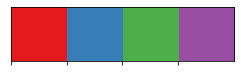

In [17]:
sns.palplot(nuclei_cmap)

In [18]:
regions_plotted = starling_atlas.brain_labels.loc[nuclei_to_plot]
regions_plotted['colors'] = list(nuclei_cmap)

In [19]:
regions_plotted

,label,region,type_,colors
region,,,,
Field_L,1,Field_L,Nuclei,"(0.8941176470588236, 0.10196078431372549, 0.10..."
NCM,2,NCM,Nuclei,"(0.21568627450980393, 0.49411764705882355, 0.7..."
CMM,5,CMM,Nuclei,"(0.30196078431372547, 0.6862745098039216, 0.29..."
Nidopallium,1,Nidopallium,Brainregions,"(0.596078431372549, 0.3058823529411765, 0.6392..."


In [20]:
color_dict = {row.region:row.colors for idx, row in regions_plotted.iterrows()}

In [21]:
color_dict

{'Field_L': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 'NCM': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 'CMM': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 'Nidopallium': (0.596078431372549, 0.3058823529411765, 0.6392156862745098)}

In [22]:
# create dictionary of voxel locations for nuclei
voxels_nuclei = starling_atlas.voxel_data.loc['Nuclei', 'voxels']
voxels_brainregions = starling_atlas.voxel_data.loc['Brainregions', 'voxels']
vox_dict = {}
for ri, region_row in regions_plotted.iterrows():
    if region_row.type_ == 'Nuclei':
        region_voxels = np.array(np.where(voxels_nuclei == region_row.label))
    elif region_row.type_ == "Brainregions":
        region_voxels = np.array(np.where(voxels_brainregions == region_row.label))
    print(region_voxels.shape)
    vox_dict[region_row.region] = region_voxels

(3, 10515)
(3, 26881)
(3, 6337)
(3, 792729)


In [23]:
# convert voxel dict to um
um_dict = {key:np.vstack([vox_to_um(
    i,
    starling_atlas.voxel_data.loc["Brain", "affine"],
    starling_atlas.um_mult,
    starling_atlas.y_sinus_um_transform,
) for i in tqdm(values.T, leave=False)]) for key, values in tqdm(vox_dict.items())}

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10515 [00:00<?, ?it/s]

  0%|          | 0/26881 [00:00<?, ?it/s]

  0%|          | 0/6337 [00:00<?, ?it/s]

  0%|          | 0/792729 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

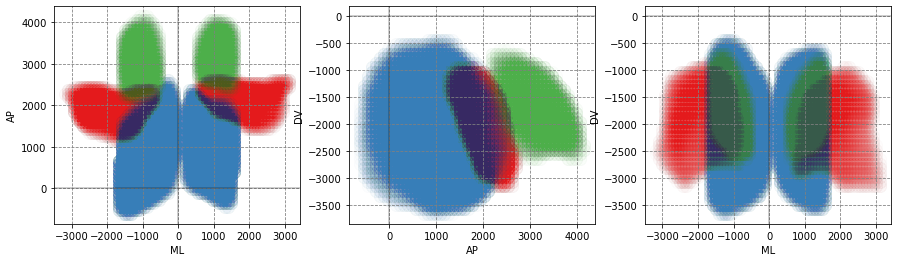

In [24]:
axis_names = ["ML", "AP", "DV"]
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
for axi, (i, j) in enumerate(tqdm([[0,1], [1,2], [0,2]])):
    ax = axs[axi]
    for region, region_voxels in um_dict.items():
        if region == "Nidopallium":
            continue
        ax.scatter(region_voxels[:,i], region_voxels[:,j], s = 150, color = color_dict[region], alpha = 0.01)
    ax.axvline(0, color = 'k', alpha = 0.25)
    ax.axhline(0, color = 'k', alpha = 0.25)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.set_xlabel(axis_names[i])
    ax.set_ylabel(axis_names[j])

In [25]:
# Mask NCL to be lateral of NCM
NCM_ML_min = np.min(um_dict["NCM"][:,0])
NCM_ML_max = np.max(um_dict["NCM"][:,0])
NCM_AP_max = np.max(um_dict["NCM"][np.abs(um_dict["NCM"][:,0]) > 1000][:,1])

nidopallium_mask = (
    (um_dict["Nidopallium"][:, 0] < NCM_ML_min)
    | (um_dict["Nidopallium"][:, 0] > NCM_ML_max)
) & (um_dict["Nidopallium"][:, 1] < NCM_AP_max)
um_dict["Nidopallium"] = um_dict["Nidopallium"][nidopallium_mask]

In [26]:
import scipy.spatial
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

In [27]:
# NCL does not lie above NCM
L_chull = scipy.spatial.ConvexHull(um_dict["Field_L"][:,(0,1)])
L_mask = np.array([point_in_hull(i, L_chull) == False for i in tqdm(um_dict["Nidopallium"][:,(0,1)])])
um_dict["Nidopallium"] = um_dict["Nidopallium"][L_mask]

  0%|          | 0/476251 [00:00<?, ?it/s]

In [28]:
# NCL does not lie above NCM
L_chull = scipy.spatial.ConvexHull(um_dict["CMM"][:,(0,1)])
L_mask = np.array([point_in_hull(i, L_chull) == False for i in tqdm(um_dict["Nidopallium"][:,(0,1)])])
um_dict["Nidopallium"] = um_dict["Nidopallium"][L_mask]

  0%|          | 0/466169 [00:00<?, ?it/s]

In [29]:
um_dict["NCL"] = um_dict["Nidopallium"]
um_dict.pop("Nidopallium");

In [30]:
color_dict['NCL'] = color_dict['Nidopallium']

### Plot locations

In [31]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [32]:
unit_statistics_df

,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,unit,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,bird,categorical_unit,categoricality
1,NaN,NaN,NCL,415.88,2917.25,2420.0,-722.499502,9724,5612,9,0,0,0,5600,12,53828,B1597,True,0.404559
2,NaN,NaN,NCL,503.047,2717.25,2420.0,-722.499502,7843,1273,1043,150,975,387,0,1273,17587,B1597,True,0.234848
3,NaN,NaN,Field_L,527.999,2171.25,2420.0,-702.499502,5911,6279,540,106,559,226,5603,676,67114,B1597,True,0.142880
5,NaN,NaN,Field_L,601.564,2524.25,2420.0,-762.499502,958,6206,1,0,0,0,6205,1,8064,B1597,True,0.111902
6,NaN,NaN,Field_L,581.814,2531.25,2420.0,-802.499502,1613,5721,126,17,113,27,5582,139,952,B1597,True,0.187621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12215,NaN,NaN,NCM,579.802,-1000.0,1901.25,-182.499497,8145,5370,942,129,857,219,4208,1162,83778,B1248,True,0.338975
12216,NaN,NaN,CMM,590.24,1000.0,2268.75,-352.499502,10134,5332,973,137,836,204,4182,1150,124045,B1248,True,0.433915
12221,NaN,NaN,NCM,503.951,-1000.0,1854.25,-242.499497,3223,6399,1511,422,1294,232,4570,1829,140659,B1248,True,0.380692
12222,NaN,NaN,CMM,558.936,1000.0,2275.75,-392.499502,7575,5236,806,115,725,173,4204,1032,105808,B1248,True,0.376903


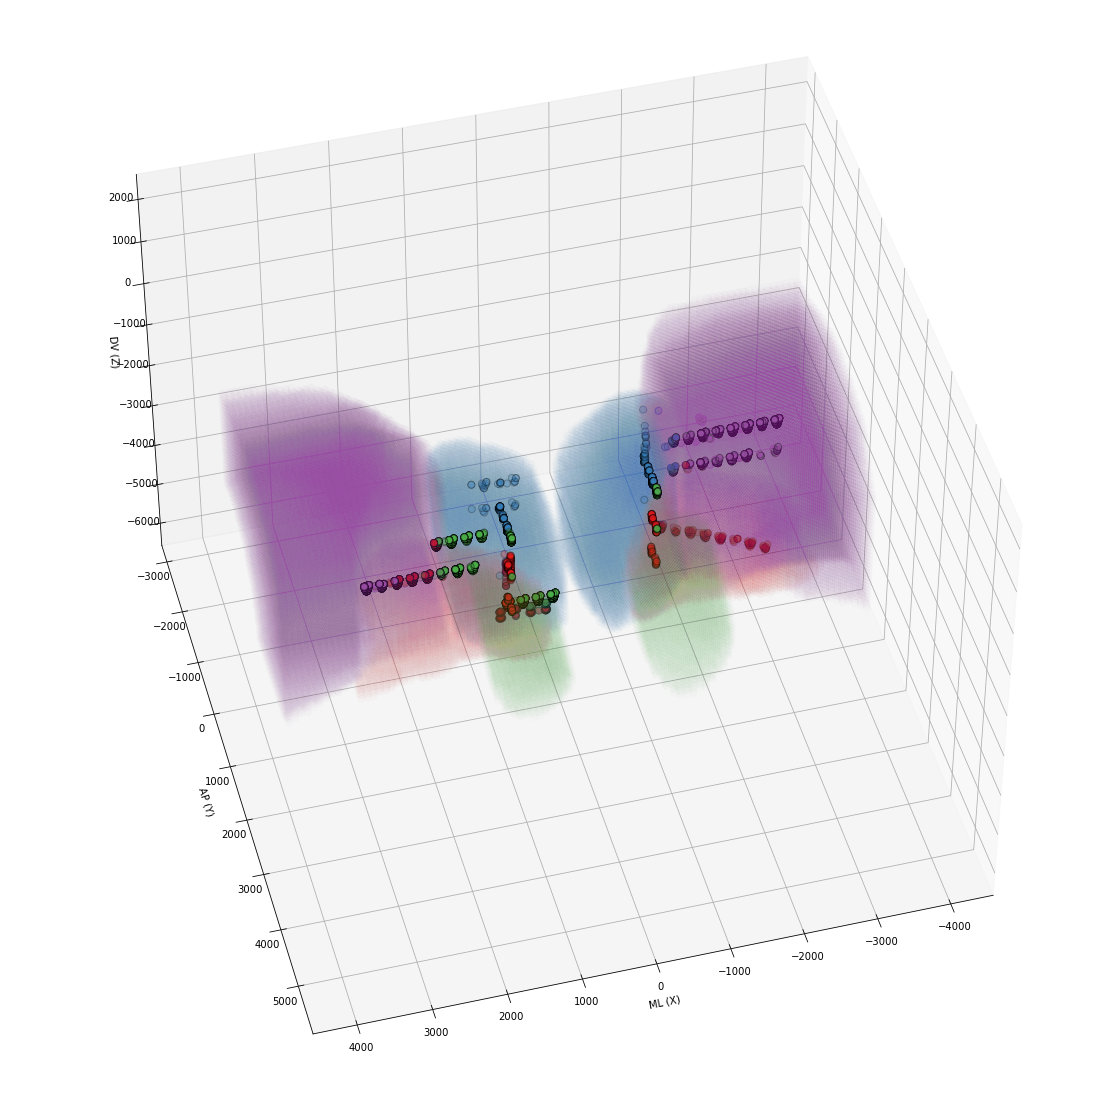

In [33]:
sr = 1

z_range = [-4500, 500]
x_range = [-4000, 4000]
y_range = [-1500, 4000]


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection="3d")
for region, region_voxels in um_dict.items():
    if region == "NCL":
        sr = 1
    else:
        sr=1
        
    mask = (
        (region_voxels[:, 0] < x_range[1]) &
        (region_voxels[:, 0] > x_range[0]) &
        (region_voxels[:, 1] < y_range[1]) &
        (region_voxels[:, 1] > y_range[0]) &
        (region_voxels[:, 2] < z_range[1]) &
        (region_voxels[:, 2] > z_range[0]) 
    )
    
    ax.scatter(
        region_voxels[mask][:, 0][::sr],
        region_voxels[mask][:, 1][::sr],
        region_voxels[mask][:, 2][::sr],
        s=50,
        color=color_dict[region],
        alpha=0.015,
        rasterized=True
    )

ax.set_xlabel("ML (X)")
ax.set_ylabel("AP (Y)")
ax.set_zlabel("DV (Z)")



for bird in unit_statistics_df.bird.unique():
    #if bird in acute_birds:
    #    continue
    mask = unit_statistics_df.bird == bird
    ML = unit_statistics_df[mask].ML.values
    AP = unit_statistics_df[mask].AP.values
    DV = unit_statistics_df[mask].DV.values
    c = [color_dict[i] for i in unit_statistics_df[mask].estimated_nuclei]
    ax.scatter(ML, AP, DV, s=50, alpha=0.25, edgecolor='k',  c=c)


if True:
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array(
        [x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0]]
    ).max()
    Xb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][0].flatten() + 0.5 * (
        np.sum(x_range)
    )
    Yb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][1].flatten() + 0.5 * (
        np.sum(y_range)
    )
    Zb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][2].flatten() + 0.5 * (
        np.sum(z_range)
    )
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], "w")
else:
    ax.auto_scale_xyz(x_range, y_range, z_range)

#ax.view_init(elev=55, azim=55)
ax.view_init(elev=45, azim=75)

ensure_dir(FIGURE_DIR / 'unit_locations')
save_fig(FIGURE_DIR / 'unit_locations' / 'unit_scatter', save_pdf=True, save_svg=True)
plt.show()


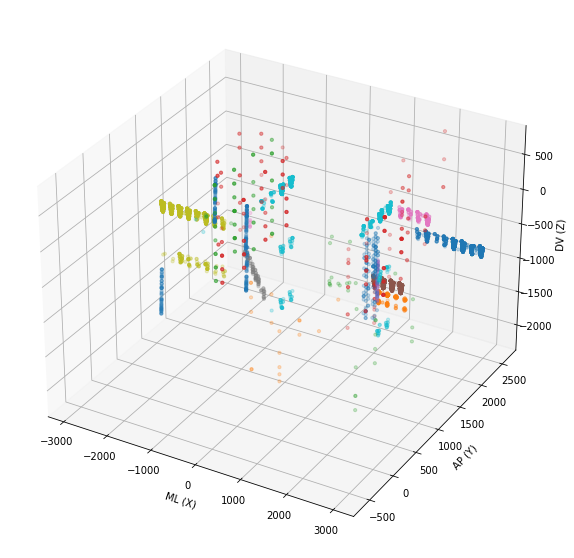

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for bird in unit_statistics_df.bird.unique():
    mask= unit_statistics_df.bird == bird
    ML = unit_statistics_df[mask].ML.values
    AP = unit_statistics_df[mask].AP.values
    DV = unit_statistics_df[mask].DV.values
    ax.scatter(ML, AP, DV, s = 10, alpha = 0.25)
    
ax.set_xlabel('ML (X)')
ax.set_ylabel('AP (Y)')
ax.set_zlabel('DV (Z)')

#ax.view_init(-140, -60)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

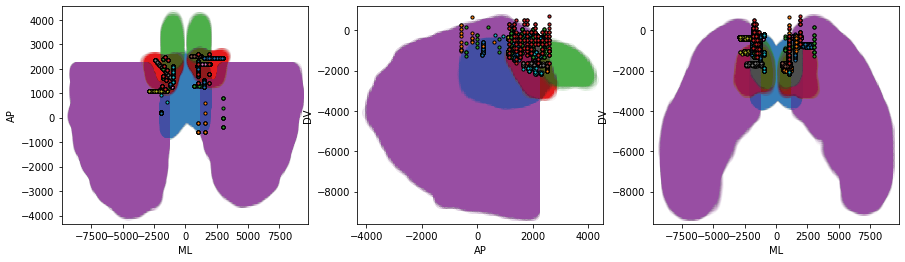

In [56]:
axis_names = ["ML", "AP", "DV"]
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
for axi, (i, j) in enumerate(tqdm([[0,1], [1,2], [0,2]])):
    ax = axs[axi]
    for region, region_voxels in um_dict.items():
        if region == "Nidopallium":
            continue
        ax.scatter(region_voxels[:,i], region_voxels[:,j], s = 150, color = color_dict[region], alpha = 0.01)
    for bird in unit_statistics_df.bird.unique():
        mask= unit_statistics_df.bird == bird
        ML = unit_statistics_df[mask].ML.values
        AP = unit_statistics_df[mask].AP.values
        DV = unit_statistics_df[mask].DV.values
        sites = np.stack([ML,AP,DV])
        ax.scatter(sites[i,:], sites[j,:], s= 10, alpha = 1, edgecolor='k')
        ax.set_xlabel(axis_names[i])
        ax.set_ylabel(axis_names[j])

B1597


  0%|          | 0/3 [00:00<?, ?it/s]

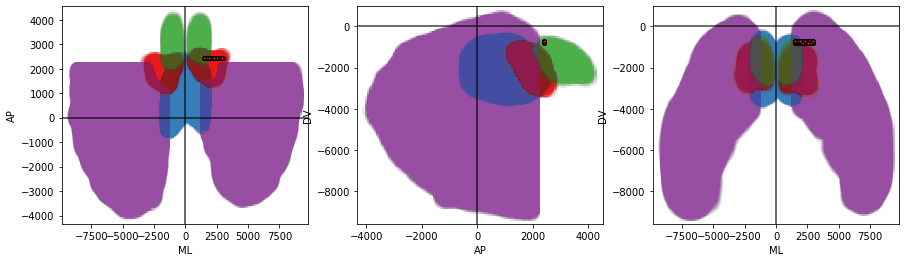

B1188


  0%|          | 0/3 [00:00<?, ?it/s]

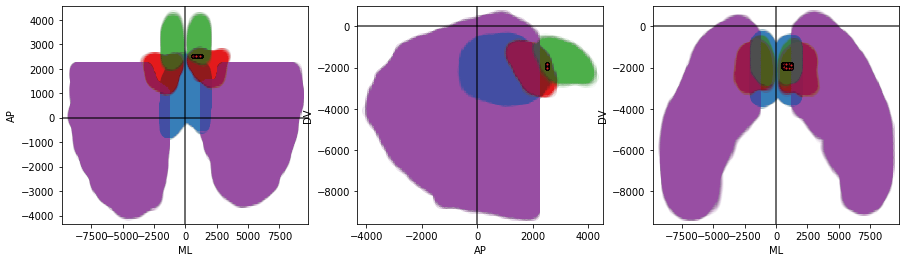

B1595


  0%|          | 0/3 [00:00<?, ?it/s]

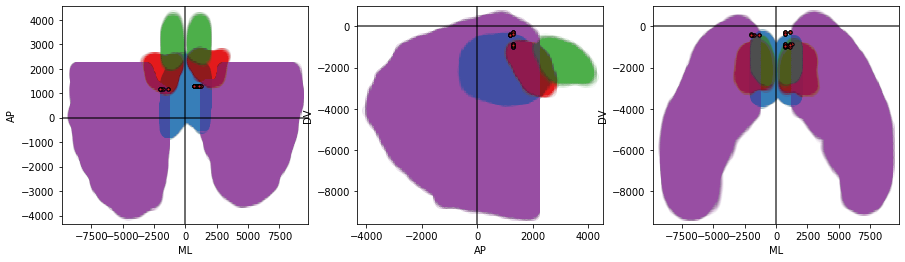

B1276


  0%|          | 0/3 [00:00<?, ?it/s]

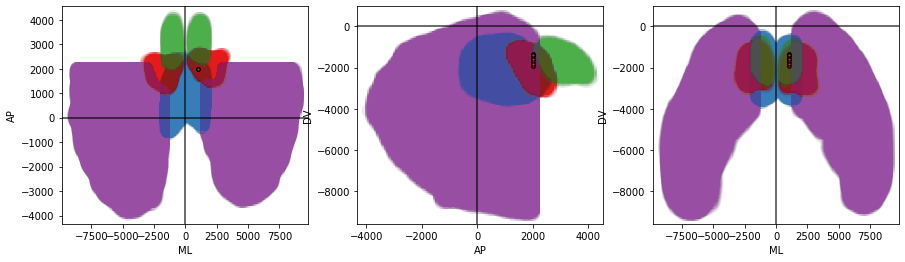

B1426


  0%|          | 0/3 [00:00<?, ?it/s]

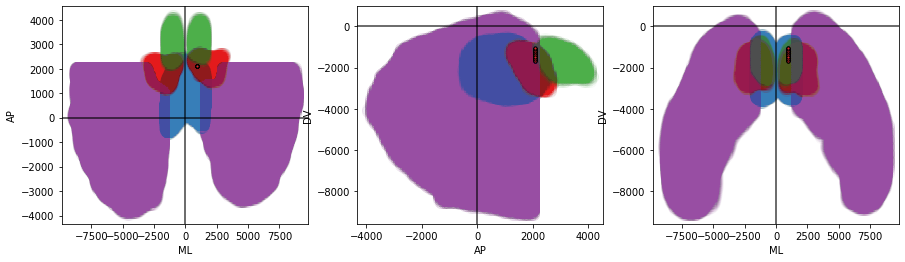

B1432


  0%|          | 0/3 [00:00<?, ?it/s]

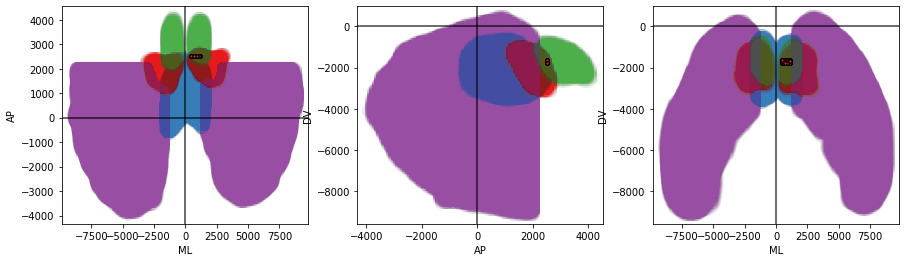

B1170


  0%|          | 0/3 [00:00<?, ?it/s]

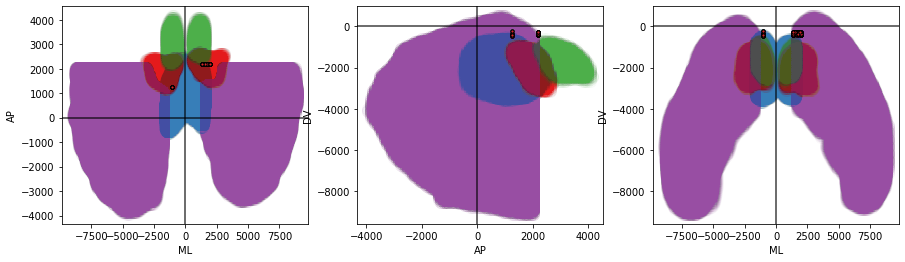

B1244


  0%|          | 0/3 [00:00<?, ?it/s]

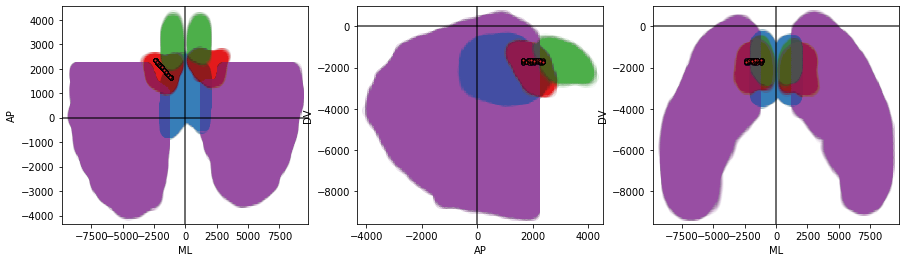

B1593


  0%|          | 0/3 [00:00<?, ?it/s]

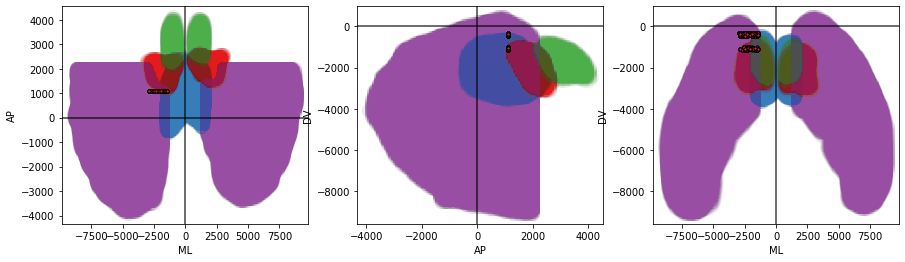

B1248


  0%|          | 0/3 [00:00<?, ?it/s]

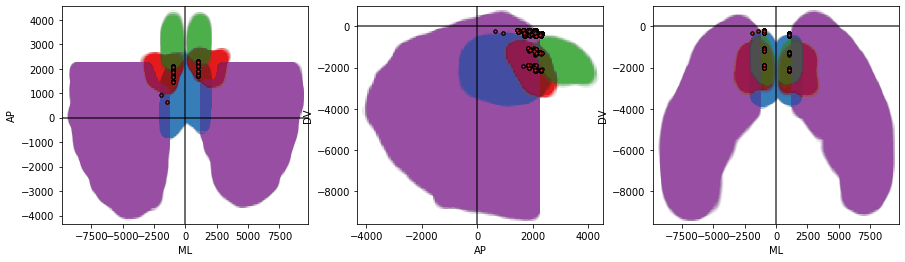

B1279


  0%|          | 0/3 [00:00<?, ?it/s]

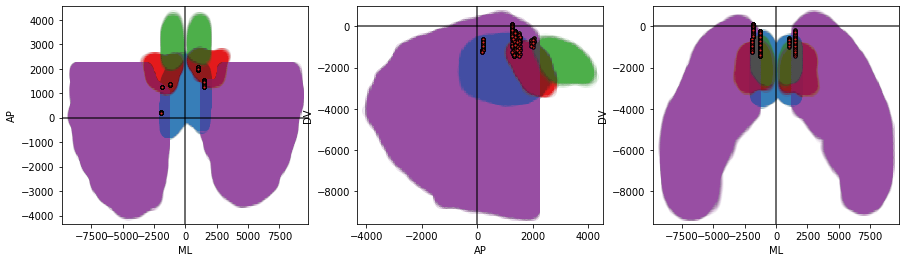

B1500


  0%|          | 0/3 [00:00<?, ?it/s]

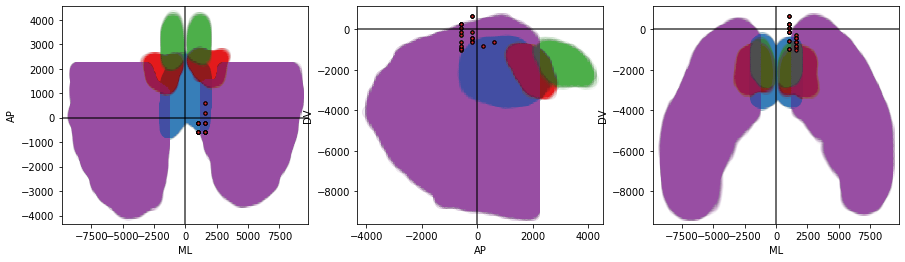

B1239


  0%|          | 0/3 [00:00<?, ?it/s]

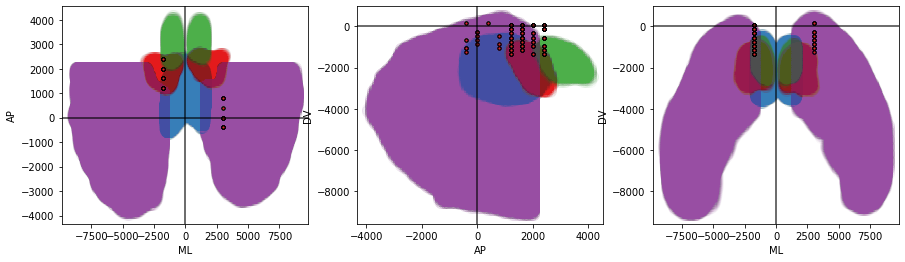

B1459


  0%|          | 0/3 [00:00<?, ?it/s]

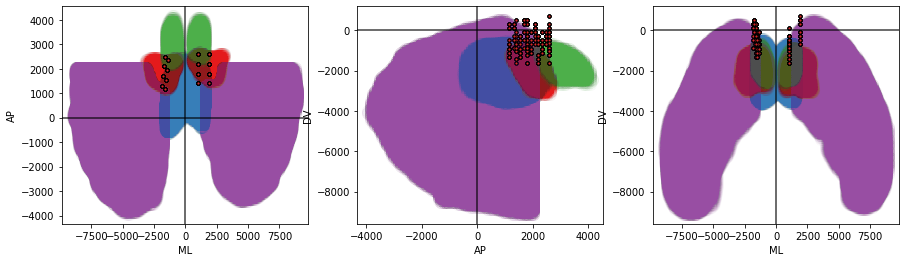

In [57]:
for bird in unit_statistics_df.bird.unique():
    print(bird)
    axis_names = ["ML", "AP", "DV"]
    fig, axs = plt.subplots(ncols=3, figsize=(15,4))
    for axi, (i, j) in enumerate(tqdm([[0,1], [1,2], [0,2]])):
        ax = axs[axi]
        for region, region_voxels in um_dict.items():
            if region == "Nidopallium":
                continue
            ax.scatter(region_voxels[:,i], region_voxels[:,j], s = 150, color = color_dict[region], alpha = 0.01)

            mask= unit_statistics_df.bird == bird
            ML = unit_statistics_df[mask].ML.values
            AP = unit_statistics_df[mask].AP.values
            DV = unit_statistics_df[mask].DV.values
            sites = np.stack([ML,AP,DV])
            ax.scatter(sites[i,:], sites[j,:], s= 10, alpha = 1, edgecolor='k')
            ax.set_xlabel(axis_names[i])
            ax.set_ylabel(axis_names[j])
            ax.axvline(0, color = 'k', alpha = 0.25)
            ax.axhline(0, color = 'k', alpha = 0.25)
    plt.show()

In [58]:
unit_statistics_df[:3]

,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,unit,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,bird,categorical_unit
6,NaN,NaN,NCL,416.664,2910.25,2420.0,-682.499502,12548,8087,2450,135,2717,814,5183,2904,14500,B1597,True
8,NaN,NaN,NCL,415.88,2917.25,2420.0,-722.499502,9724,5612,9,0,0,0,5600,12,53828,B1597,True
18,NaN,NaN,Field_L,558.515,2317.25,2420.0,-722.499502,97,6216,6,0,0,0,6208,8,52365,B1597,True


In [89]:
location_counts = pd.DataFrame(np.unique(unit_statistics_df.estimated_nuclei, return_counts = True)).T
location_counts.columns = ['location', 'n']
location_counts

,location,n
0,CMM,1493
1,Field_L,1518
2,NCL,1999
3,NCM,806


<AxesSubplot:xlabel='location', ylabel='n'>

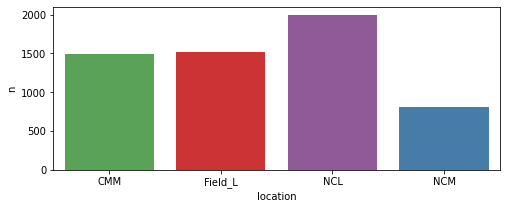

In [94]:
fig, ax = plt.subplots(figsize=(8,3))
sns.barplot(x = 'location', y='n', data=location_counts, palette=color_dict, ax = ax)

In [63]:
np.unique(unit_statistics_df[unit_statistics_df.distance_to_estimated_nuclei.values < 100].estimated_nuclei, return_counts = True)

(array(['CMM', 'Field_L', 'NCL', 'NCM'], dtype=object),
 array([ 522,  812, 1207,  186]))

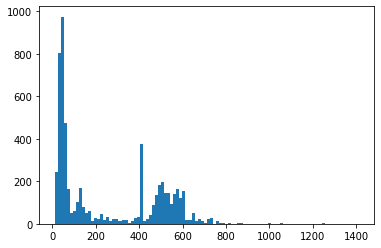

In [64]:
plt.hist(unit_statistics_df.distance_to_estimated_nuclei.values, bins = 100);